# **Código Grupo 8 - Trabajo Práctico N° 3 Clasificando de pobres con la EPH**


**Autores:**

Jorge Eduardo Bolaños Gamarra

Mario Antonio Valdivia Reyes

Hector Sebastian San Martin


In [62]:
# =========================================================
# 1. IMPORTAR LIBRERÍAS
# =========================================================

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Métricas de evaluación
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    f1_score,
    classification_report
)

# Estadística
from scipy.stats import ttest_ind
import statsmodels.api as sm


In [63]:
# Importar datos
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Cargar df
path = "/content/drive/MyDrive/Taller de Programación - UBA/TP3/respondieron.xlsx"
df = pd.read_excel(path)

print("✅ Datos cargados desde Drive correctamente:")
df.head()


✅ Datos cargados desde Drive correctamente:


,CODUSU,NRO_HOGAR,COMPONENTE,CH04,CH06,CH07,CH08,ITF,NIVEL_ED,ESTADO,...,AD_EQUIV_HOGAR,POBRE,EDAD2,AEDUC,HORASTRAB2,ingreso_total_familiar,cluster_k3,cluster_k2,cluster_k4,cluster_k10
0,125082,1,1,NaN,28,2,No paga ni le descuentan,840,2,Ocupado,...,0.0,0,784.0,8.0,72,1.495824e+06,1,1,1,9
1,125082,1,2,NaN,30,2,Obra social (incluye PAMI),840,6,Ocupado,...,0.0,0,900.0,16.0,42,1.495824e+06,1,1,1,6
2,125082,1,3,NaN,4,5,Obra social (incluye PAMI),840,0,Menor de 10 años,...,0.0,0,16.0,0.0,0,1.495824e+06,1,1,3,3
3,125283,1,1,NaN,66,2,Mutual/Prepaga/Servicio de emergencia,4300,3,Ocupado,...,0.0,0,4356.0,11.0,0,7.657196e+06,0,1,0,2
4,125283,1,2,NaN,60,2,Mutual/Prepaga/Servicio de emergencia,4300,3,Ocupado,...,0.0,0,3600.0,10.0,0,7.657196e+06,0,1,0,2


In [65]:
# Revisar columnas
df.columns

Index(['CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'CH04', 'CH06', 'CH07', 'CH08',
       'ITF', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF', 'P21', 'P47T',
       'HORASTRAB', 'PP3F_TOT', 'PP04A', 'PP03D', 'DECIFR', 'CH09', 'CH10',
       'CH12', 'CH13', 'CH14', 'MIEMBROS', 'REGION', 'ANIO', 'CH10_B',
       'CH12_B', 'CH13_B', 'CH14_B', 'SEXO', 'ADULT_EQUIV', 'AD_EQUIV_HOGAR',
       'POBRE', 'EDAD2', 'AEDUC', 'HORASTRAB2', 'ingreso_total_familiar',
       'cluster_k3', 'cluster_k2', 'cluster_k4', 'cluster_k10'],
      dtype='object')

## Diccionario de Variables

### Variables de Identificación
- **CODUSU**: Código para distinguir viviendas  
- **NRO_HOGAR**: Código para distinguir hogares  
- **COMPONENTE**: Número de componente del hogar  

### Características Demográficas
- **CH04**: Sexo (1=Varón, 2=Mujer)  
- **CH06**: Edad en años cumplidos  
- **CH07**: Estado civil/conyugal  
- **CH08**: Tipo de cobertura médica  
- **CH09**: Sabe leer y escribir  
- **CH10**: Asistencia a establecimiento educativo  
- **CH12**: Nivel educativo más alto que cursa/cursó  
- **CH13**: Finalización del nivel educativo  
- **CH14**: Último año aprobado  

### Variables Laborales y Educativas
- **NIVEL_ED**: Nivel educativo alcanzado  
- **ESTADO**: Condición de actividad (ocupado, desocupado, inactivo, etc.)  
- **CAT_INAC**: Categoría de inactividad  
- **HORASTRAB**: Horas trabajadas en la semana  
- **PP3F_TOT**: Total de horas trabajadas en otras ocupaciones  
- **PP04A**: Sector del empleo (estatal, privado, etc.)  
- **PP03D**: Cantidad de ocupaciones  

### Variables de Ingresos
- **ITF**: Ingreso Total Familiar  
- **IPCF**: Ingreso Per Cápita Familiar  
- **P21**: Ingreso de la ocupación principal  
- **P47T**: Ingreso total individual  
- **DECIFR**: Decil del ingreso total familiar  

### Variables Geográficas y de Identificación
- **REGION**: Código de región geográfica  
- **ANIO**: Año de relevamiento  
- **SEXO**: Variable derivada de CH04  

### Variables Adicionales
- **CH10_B, CH12_B, CH13_B, CH14_B**: Variables binarias derivadas de las variables CH correspondientes  
- **ADULT_EQUIV**: Adulto equivalente  
- **AD_EQUIV_HOGAR**: Adulto equivalente del hogar  
- **POBRE**: Indicador de pobreza  
- **EDAD2**: Variable transformada de edad  
- **AEDUC**: Variable transformada de educación  
- **HORASTRAB2**: Variable transformada de horas trabajadas  
- **ingreso_total_familiar**: Variable derivada de ITF  
- **cluster_k3, cluster_k2, cluster_k4, cluster_k10**: Variables de clusterización  


In [66]:
# Revisar NAs en ITF
df['ITF'].isna().sum()

np.int64(0)

Punto A

In [67]:
# Variables independientes (sin ingreso)
vars_X = [
    'CH06',  # edad
    'CH07',  # estado civil
    'NIVEL_ED',  # educación
    'HORASTRAB',  # horas trabajadas
    'AD_EQUIV_HOGAR',  # tamaño equivalente del hogar
    'AEDUC'  # años de educación
]

# Variable dependiente
y = df['POBRE']

# Crear X con las variables seleccionadas
X = df[vars_X].copy()

# Agregar columna de 1s para el intercepto
X = pd.concat([pd.Series(1, index=X.index, name='constante'), X], axis=1)


In [68]:
# Dividir base
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=444
)

print("✅ División completada:")
print(f"Train: {X_train.shape[0]} observaciones")
print(f"Test:  {X_test.shape[0]} observaciones")


✅ División completada:
Train: 12686 observaciones
Test:  5437 observaciones


In [69]:
# Calcular medias
mean_train = X_train.mean()
mean_test = X_test.mean()

# Tabla de diferencias
diff_means = pd.DataFrame({
    'Media_Train': mean_train,
    'Media_Test': mean_test,
    'Diferencia': mean_train - mean_test
})

print("Diferencias de medias entre Train y Test:")
display(diff_means)

Diferencias de medias entre Train y Test:


,Media_Train,Media_Test,Diferencia
constante,1.000000,1.000000,0.000000
CH06,33.556361,34.052419,-0.496057
CH07,3.552972,3.530440,0.022532
NIVEL_ED,2.934968,2.926982,0.007986
HORASTRAB,16.681482,15.691448,0.990035
AD_EQUIV_HOGAR,0.579354,0.573187,0.006166
AEDUC,9.858156,9.825254,0.032902


In [70]:
# Tipos en X_train
X_train.dtypes

,0
constante,int64
CH06,int64
CH07,int64
NIVEL_ED,int64
HORASTRAB,float64
AD_EQUIV_HOGAR,float64
AEDUC,float64


In [71]:
# Crear una copia segura de X
X_encoded = pd.get_dummies(X, columns=['CH07', 'NIVEL_ED'], drop_first=True)

# Volver a dividir en train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.3,
    random_state=444
)

print("✅ División completada con variables dummies:")
print(f"Train: {X_train.shape[0]} filas, {X_train.shape[1]} columnas")
print(f"Test:  {X_test.shape[0]} filas, {X_test.shape[1]} columnas")

✅ División completada con variables dummies:
Train: 12686 filas, 17 columnas
Test:  5437 filas, 17 columnas


## Punto A

In [72]:
# Punto 1
# Calcular medias
mean_train = X_train.mean()
mean_test = X_test.mean()

# Tabla de diferencias
diff_means = pd.DataFrame({
    'Media_Train': mean_train,
    'Media_Test': mean_test,
    'Diferencia': mean_train - mean_test
}).sort_values('Diferencia')

print("📋 Diferencia de medias entre Train y Test:")
display(diff_means.head(15))


📋 Diferencia de medias entre Train y Test:


,Media_Train,Media_Test,Diferencia
CH06,33.556361,34.052419,-0.496057
CH07_3,0.042172,0.046717,-0.004544
NIVEL_ED_2,0.179962,0.184293,-0.004331
NIVEL_ED_6,0.098691,0.102078,-0.003387
CH07_4,0.056283,0.059592,-0.003309
NIVEL_ED_1,0.187451,0.190362,-0.002912
CH07_2,0.272978,0.274968,-0.001990
NIVEL_ED_3,0.170266,0.171602,-0.001336
CH07_1,0.121867,0.122678,-0.000811
NIVEL_ED_7,0.012691,0.013059,-0.000368


In [73]:
# Prueba estadística para significancia de las diferencias
# Calcular medias
mean_train = X_train.mean()
mean_test = X_test.mean()

# Crear tabla de diferencias con prueba t
diff_means = pd.DataFrame({
    'Media_Train': mean_train,
    'Media_Test': mean_test,
    'Diferencia': mean_train - mean_test,
    't-stat': [ttest_ind(X_train[col], X_test[col], equal_var=False).statistic for col in X_train.columns],
    'p-value': [ttest_ind(X_train[col], X_test[col], equal_var=False).pvalue for col in X_train.columns]
}).sort_values('Diferencia', key=abs, ascending=False)  # Orden por magnitud de diferencia

print("📋 Diferencia de medias y significancia entre Train y Test:")
display(diff_means.head(15))

# Prueba de significancia de la diferencia de medias entre Train y Test
# Hipótesis:
#   H0 (hipótesis nula): La media de la columna en X_train es igual a la media en X_test
#   H1 (hipótesis alternativa): La media de la columna en X_train es diferente a la media en X_test
# Se realiza un t-test de muestras independientes (Welch) para evaluar si las diferencias observadas son estadísticamente significativas


📋 Diferencia de medias y significancia entre Train y Test:


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,Media_Train,Media_Test,Diferencia,t-stat,p-value
HORASTRAB,16.681482,15.691448,0.990035,NaN,NaN
CH06,33.556361,34.052419,-0.496057,-1.366470,0.171822
AEDUC,9.858156,9.825254,0.032902,NaN,NaN
CH07_5,0.506700,0.495862,0.010839,1.337272,0.181164
NIVEL_ED_5,0.111777,0.105389,0.006388,1.273210,0.202972
AD_EQUIV_HOGAR,0.579354,0.573187,0.006166,0.278670,0.780504
CH07_3,0.042172,0.046717,-0.004544,-1.347321,0.177908
NIVEL_ED_2,0.179962,0.184293,-0.004331,-0.690910,0.489638
NIVEL_ED_4,0.159231,0.155601,0.003630,0.616038,0.537883
NIVEL_ED_6,0.098691,0.102078,-0.003387,-0.693171,0.488218


In [74]:
# Verificación de AEDUC y HORASTRAB
# HORASTRAB
print(X_train['HORASTRAB'].describe())
print(X_test['HORASTRAB'].describe())

print(X_train['HORASTRAB'].value_counts(normalize=True).head(5))

# AEDUC
print(X_train['AEDUC'].describe())
print(X_test['AEDUC'].describe())

print(X_train['AEDUC'].value_counts(normalize=True).head(5))

count    11227.000000
mean        16.681482
std         23.294639
min          0.000000
25%          0.000000
50%          0.000000
75%         36.000000
max        120.000000
Name: HORASTRAB, dtype: float64
count    4829.000000
mean       15.691448
std        22.676356
min         0.000000
25%         0.000000
50%         0.000000
75%        34.000000
max       112.000000
Name: HORASTRAB, dtype: float64
HORASTRAB
0.0     0.583949
40.0    0.053175
48.0    0.041151
30.0    0.033134
20.0    0.028681
Name: proportion, dtype: float64
count    12126.000000
mean         9.858156
std          5.073497
min          0.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         23.000000
Name: AEDUC, dtype: float64
count    5219.000000
mean        9.825254
std         5.035113
min         0.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        23.000000
Name: AEDUC, dtype: float64
AEDUC
8.0     0.195035
13.0    0.193056
16.0    0.065891
0.0    

## Interpretación

Esta tabla compara las **medias de las variables** entre los conjuntos de entrenamiento (`Media_Train`) y prueba (`Media_Test`), junto con la diferencia, el estadístico t y el p-valor de una prueba t de diferencia de medias. El objetivo es verificar si la partición de datos ha generado subconjuntos estadísticamente equivalentes.

- **Diferencia**: diferencia entre la media en entrenamiento y prueba.
- **t-stat**: estadístico t de la prueba de hipótesis.
- **p-value**: probabilidad de observar una diferencia igual o mayor si las medias fueran iguales (H₀ verdadera).

- **H₀ (nula)**: la media de la variable es igual en ambos subconjuntos.
- **H₁ (alternativa)**: las medias son diferentes.

La mayoría de las variables tienen **p-valores mayores a 0.05**, lo que indica que **no hay evidencia estadística suficiente para afirmar que las medias difieren significativamente** entre entrenamiento y prueba.

Variables como `CH06`, `CH07_5`, `CH07_3` y `NIVEL_ED_5` tienen diferencias moderadas, pero sus p-valores (> 0.17) no alcanzan significancia estadística.

Algunas variables (`HORASTRAB`, `AEDUC`) no tienen t-stat ni p-value calculados, posiblemente por falta de varianza o por ser continuas con valores extremos.

La partición de datos parece **balanceada**, ya que no se detectan diferencias significativas en la distribución de las variables entre los subconjuntos. Esto sugiere que el modelo entrenado no estará sesgado por una mala segmentación de los datos.



In [75]:
# Punto 2
# Separar respondieron y no respondieron

respondieron_2005 = df[df['ANIO'] == 2005].copy()
respondieron_2025 = df[df['ANIO'] == 2025].copy()

# Ruta para 'norespondieron.csv'
path_norespondieron = "/content/drive/MyDrive/Taller de Programación - UBA/TP3/norespondieron.xlsx"
norespondieron = pd.read_excel(path_norespondieron)
norespondieron_2005 = norespondieron[norespondieron['ANIO'] == 2005].copy()
norespondieron_2025 = norespondieron[norespondieron['ANIO'] == 2025].copy()

In [76]:
# Revisar contenido y comparar respondieron y no respondieron
for name, base in {
    "respondieron_2005": respondieron_2005,
    "respondieron_2025": respondieron_2025,
    "norespondieron_2005": norespondieron_2005,
    "norespondieron_2025": norespondieron_2025
}.items():
    print(f"{name}: {base.shape[0]:,} observaciones")


respondieron_2005: 14,760 observaciones
respondieron_2025: 3,363 observaciones
norespondieron_2005: 198 observaciones
norespondieron_2025: 1,406 observaciones


Punto B

In [77]:
# Preparar variables

# Variables explicativas (sin ingresos)
vars_X = [
    'CH06',            # edad
    'HORASTRAB',       # horas trabajadas
    'AD_EQUIV_HOGAR',  # tamaño del hogar
    'AEDUC',            # años de educación
   ]

# Variable dependiente
y = respondieron_2025['POBRE']
X = respondieron_2025[vars_X].copy()

# Agregar constante
X = sm.add_constant(X)

In [78]:
# Estimar modelo logit

# logit_model = sm.Logit(y, X).fit() # Commented out the failing line

# Verificar valores nulos en X
missing_values = X.isnull().sum()
print('Valores nulos por columna en X:')
print(missing_values[missing_values > 0])

# Opcional: Eliminar filas con valores nulos (una de las formas de manejarlo)
X_cleaned = X.dropna()
y_cleaned = y.loc[X_cleaned.index]
logit_model = sm.Logit(y_cleaned, X_cleaned).fit()

# Resumen
print(logit_model.summary())

Valores nulos por columna en X:
HORASTRAB    2059
AEDUC          30
dtype: int64
Optimization terminated successfully.
         Current function value: 0.568666
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  POBRE   No. Observations:                 1292
Model:                          Logit   Df Residuals:                     1287
Method:                           MLE   Df Model:                            4
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.1578
Time:                        14:40:09   Log-Likelihood:                -734.72
converged:                       True   LL-Null:                       -872.37
Covariance Type:            nonrobust   LLR p-value:                 2.297e-58
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              

## Diagnóstico del modelo logit y calidad de datos

El modelo logit converge correctamente y es altamente significativo (LLR p-value ≈ 0), con un pseudo R² de 0.1578, lo que indica una capacidad explicativa moderada.

- **Coeficientes clave**:
  - `AEDUC` y `HORASTRAB` tienen efectos negativos significativos: más educación y más horas trabajadas reducen la probabilidad de pobreza.
  - `AD_EQUIV_HOGAR` tiene un efecto positivo fuerte: hogares más grandes aumentan el riesgo de pobreza.

In [79]:
# Punto 3

# Coeficientes y errores estándar
coef = logit_model.params
std_err = logit_model.bse
odds_ratios = np.exp(coef)

tabla_resultados = pd.DataFrame({
    'Coeficiente': coef,
    'Error estándar': std_err,
    'Odds Ratio (exp(beta))': odds_ratios
}).round(4)

print("Tabla de resultados:")
display(tabla_resultados)


Tabla de resultados:


,Coeficiente,Error estándar,Odds Ratio (exp(beta))
const,1.7710,0.4443,5.8768
CH06,-0.0186,0.0053,0.9815
HORASTRAB,-0.0095,0.0036,0.9906
AD_EQUIV_HOGAR,0.5200,0.0519,1.6820
AEDUC,-0.2020,0.0208,0.8171


## Interpretación de coeficientes y odds ratios

Los odds ratios permiten interpretar el efecto de cada variable en términos de multiplicadores de probabilidad.

- **CH06 (Edad)**: Coeficiente negativo (−0.0186) y odds ratio de 0.9815 → cada año adicional de edad **reduce la probabilidad de pobreza en ~1.85%**, manteniendo las demás variables constantes.

- **HORASTRAB (Horas trabajadas)**: Coeficiente negativo (−0.0095) y odds ratio de 0.9906 → trabajar una hora más **reduce la probabilidad de pobreza en ~0.94%**, lo que sugiere un efecto protector del empleo.

- **AD_EQUIV_HOGAR (Tamaño equivalente del hogar)**: Coeficiente positivo (0.5200) y odds ratio de 1.6820 → hogares más grandes **aumentan la probabilidad de pobreza en ~68.2%**, posiblemente por mayor carga económica.

- **AEDUC (Años de educación)**: Coeficiente negativo (−0.2020) y odds ratio de 0.8171 → cada año adicional de educación **reduce la probabilidad de pobreza en ~18.3%**, mostrando un efecto fuerte y protector.

Estos resultados son coherentes con la teoría: **más educación, más edad y más horas trabajadas reducen el riesgo de pobreza**, mientras que hogares más grandes lo aumentan.


In [80]:
# Métricas adicionales (matriz de confusión, reporte y AUC)

# --- Predicciones ---
y_pred_prob = logit_model.predict(X_cleaned)                # Probabilidades
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)                 # Clasificación binaria (umbral 0.5)

# --- Matriz de confusión ---
cm = confusion_matrix(y_cleaned, y_pred)
print("Matriz de confusión:")
print(cm)

# --- Reporte de métricas ---
print("\n Reporte de métricas:")
print(classification_report(y_cleaned, y_pred, digits=3))

# --- Cálculo del AUC ---
auc = roc_auc_score(y_cleaned, y_pred_prob)
print(f"\n AUC: {auc:.3f}")


Matriz de confusión:
[[628 140]
 [251 273]]

 Reporte de métricas:
              precision    recall  f1-score   support

           0      0.714     0.818     0.763       768
           1      0.661     0.521     0.583       524

    accuracy                          0.697      1292
   macro avg      0.688     0.669     0.673      1292
weighted avg      0.693     0.697     0.690      1292


 AUC: 0.761


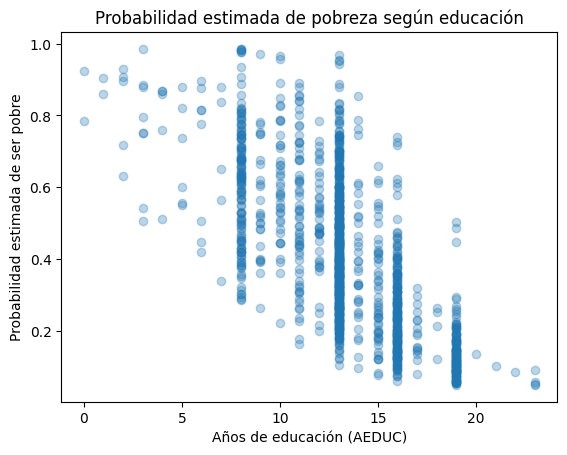

In [81]:
# Punto 4
# Calcular las probabilidades estimadas
respondieron_2025['phat'] = logit_model.predict(X)

# Graficar P(pobre=1 | educación)
plt.scatter(respondieron_2025['AEDUC'], respondieron_2025['phat'], alpha=0.3)
plt.xlabel('Años de educación (AEDUC)')
plt.ylabel('Probabilidad estimada de ser pobre')
plt.title('Probabilidad estimada de pobreza según educación')
plt.show()


## Punto C

In [82]:
# Punto 5

# -----------------------------
# Preparar los datos
# -----------------------------
# Supongamos que X_train, X_test, y_train, y_test provienen de "respondieron_2025"

# 1.1 Imputar valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 1.2 Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# -----------------------------
# Estimación KNN con K=1,5,10
# -----------------------------
k_values = [1, 5, 10]
knn_models = {}

print("Accuracy en Test para distintos K:")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_models[k] = knn
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"K={k} -> Accuracy: {acc:.3f}")

# Comentario sobre trade-off sesgo-varianza
# K pequeño (ej. 1) -> baja sesgo, alta varianza (sobreajuste)
# K grande (ej. 10) -> alto sesgo, baja varianza (subajuste)


Accuracy en Test para distintos K:
K=1 -> Accuracy: 0.939
K=5 -> Accuracy: 0.942
K=10 -> Accuracy: 0.942


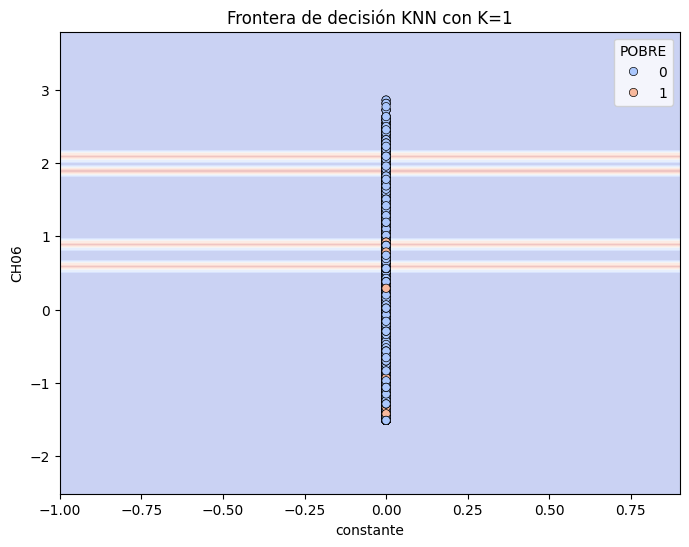

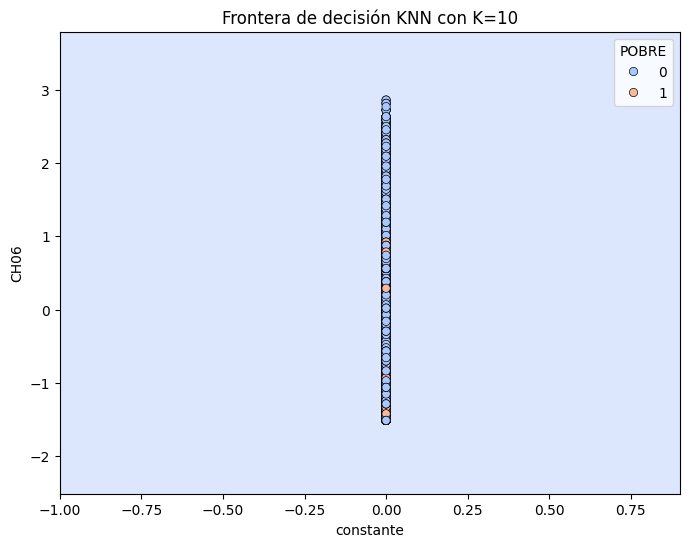

In [83]:
# Punto 6
# -----------------------------
# Visualización de fronteras de decisión (2 variables numéricas)
# -----------------------------
# Elegimos las dos primeras columnas como ejemplo
features_plot = X_train.columns[:2]
X_plot_train = X_train_scaled[:, :2]

for k in [1, 10]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_plot_train, y_train)

    # Crear malla para la frontera
    x_min, x_max = X_plot_train[:, 0].min() - 1, X_plot_train[:, 0].max() + 1
    y_min, y_max = X_plot_train[:, 1].min() - 1, X_plot_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    sns.scatterplot(x=X_plot_train[:, 0], y=X_plot_train[:, 1], hue=y_train, palette='coolwarm', edgecolor='k')
    plt.title(f'Frontera de decisión KNN con K={k}')
    plt.xlabel(features_plot[0])
    plt.ylabel(features_plot[1])
    plt.show()



**Interpretación**

El gráfico muestra la frontera de decisión del modelo KNN con K=1 utilizando las variables “constante” y “CH06”.

Se observa que la variable “constante” no aporta información discriminante (todos los valores son similares), por lo que la separación entre clases ocurre principalmente a lo largo de “CH06”.

Con K=1, el modelo produce fronteras muy irregulares y sensibles a los valores individuales del conjunto de entrenamiento, lo que puede llevar a sobreajuste (alta varianza).

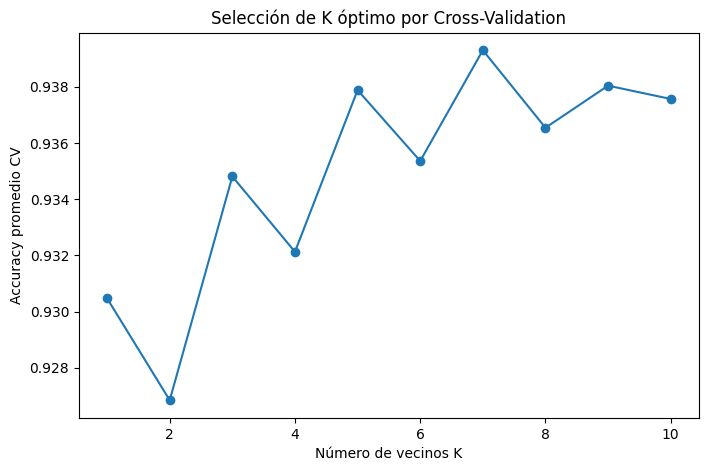

K óptimo por Cross-Validation: 7


In [84]:
# Punto 7

# Selección de K óptimo por Cross-Validation

k_range = range(1, 11)
cv_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=kf, scoring='accuracy')
    cv_scores.append(scores.mean())

# Graficar accuracies
plt.figure(figsize=(8,5))
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel('Número de vecinos K')
plt.ylabel('Accuracy promedio CV')
plt.title('Selección de K óptimo por Cross-Validation')
plt.show()

# Elegir K óptimo
k_opt = k_range[np.argmax(cv_scores)]
print(f'K óptimo por Cross-Validation: {k_opt}')


## Interpretación de la selección de K óptimo por Cross-Validation

El gráfico muestra cómo varía la **accuracy promedio** del modelo KNN en función del número de vecinos $ K $, evaluado mediante **validación cruzada**.

Se observa que el rendimiento fluctúa entre $ K = 2 $ y $ K = 10 $, alcanzando su **máximo en $ K = 7 $**, lo que sugiere que este valor ofrece el mejor equilibrio entre sesgo y varianza.

Valores de $ K $ muy bajos (como 2 o 3) pueden **sobreajustar** el modelo, mientras que valores altos (como 9 o 10) tienden a **subajustar**, perdiendo sensibilidad a patrones locales.

Elegir $ K = 7 $ como hiperparámetro óptimo mejora la **generalización del modelo** y reduce el riesgo de errores sistemáticos en predicción.


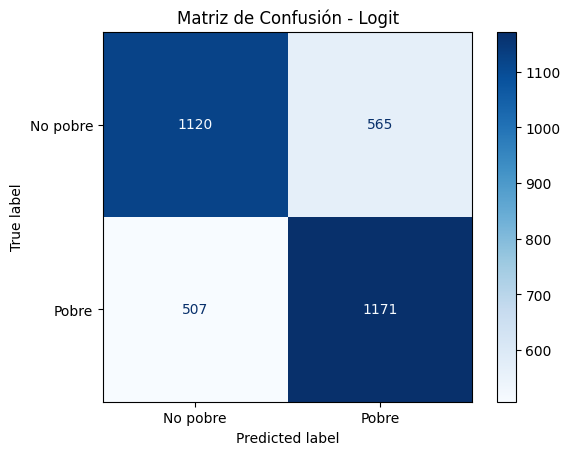

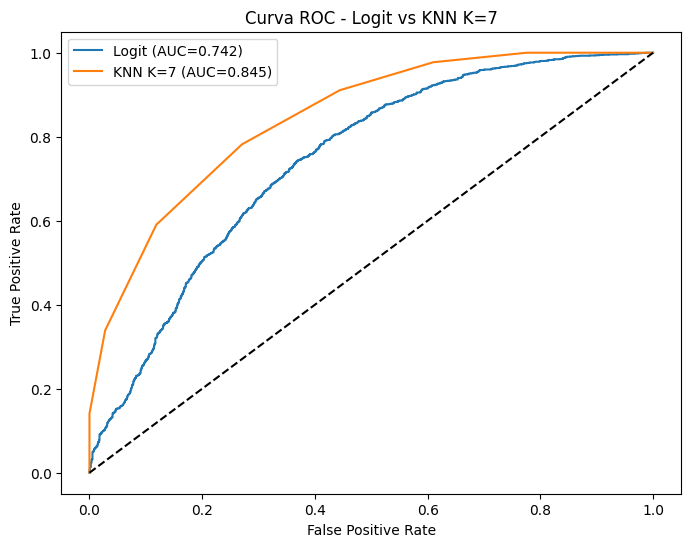

Métricas de clasificación:


,Modelo,Accuracy,F1-score,AUC
0,Logit,0.681237,0.685999,0.742169
1,KNN K=7,0.755575,0.761463,0.844706


In [85]:
# Punto 8

# -----------------------------
# Preparación de datos
# -----------------------------
vars_X = [
    'CH06',            # edad
    'HORASTRAB',       # horas trabajadas
    'AD_EQUIV_HOGAR',  # tamaño del hogar
    'AEDUC',           # años de educación
]

X = respondieron_2025[vars_X].copy()
y = respondieron_2025['POBRE']

# Agregar constante para Logit
X = sm.add_constant(X)

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_imputed_array = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns, index=X.index)
y_cleaned = y.loc[X_imputed.index]

# Escalar para KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# -----------------------------
# Predicciones con Logit ya estimado
# -----------------------------
y_prob_logit = logit_model.predict(X_imputed)
y_pred_logit = (y_prob_logit > 0.5).astype(int)

# Matriz de confusión Logit
cm = confusion_matrix(y_cleaned, y_pred_logit)
disp = ConfusionMatrixDisplay(cm, display_labels=['No pobre', 'Pobre'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Logit')
plt.show()

# -----------------------------
# KNN con K=7
# -----------------------------
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_7.fit(X_scaled, y_cleaned)
y_pred_knn = knn_7.predict(X_scaled)
y_prob_knn = knn_7.predict_proba(X_scaled)[:, 1]

# -----------------------------
# Curva ROC de ambos modelos
# -----------------------------
fpr_logit, tpr_logit, _ = roc_curve(y_cleaned, y_prob_logit)
fpr_knn, tpr_knn, _ = roc_curve(y_cleaned, y_prob_knn)

auc_logit = roc_auc_score(y_cleaned, y_prob_logit)
auc_knn = roc_auc_score(y_cleaned, y_prob_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logit, tpr_logit, label=f'Logit (AUC={auc_logit:.3f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN K=7 (AUC={auc_knn:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Logit vs KNN K=7')
plt.legend()
plt.show()

# -----------------------------
# Tabla de métricas
# -----------------------------
metrics = pd.DataFrame({
    'Modelo': ['Logit', 'KNN K=7'],
    'Accuracy': [accuracy_score(y_cleaned, y_pred_logit),
                 accuracy_score(y_cleaned, y_pred_knn)],
    'F1-score': [f1_score(y_cleaned, y_pred_logit),
                 f1_score(y_cleaned, y_pred_knn)],
    'AUC': [auc_logit, auc_knn]
})

print("Métricas de clasificación:")
display(metrics)


In [86]:
# Punto 10

# Predicción de pobreza en norespondieron_2025 con el KNN ya entrenado (knn_7)

# Variables explicativas (las mismas del entrenamiento)
vars_X = [
    'CH06',            # edad
    'HORASTRAB',       # horas trabajadas
    'AD_EQUIV_HOGAR',  # tamaño del hogar
    'AEDUC',           # años de educación
]

# Seleccionar las columnas de interés
X_no = norespondieron_2025[vars_X].copy()

# Agregar constante (para mantener la misma estructura que el entrenamiento)
X_no = sm.add_constant(X_no, has_constant='add')

# Imputar valores faltantes con la media (mismo método que en entrenamiento)
imputer = SimpleImputer(strategy='mean')
X_no_imputed = pd.DataFrame(
    imputer.fit_transform(X_no),
    columns=X_no.columns,
    index=X_no.index
)

# Escalar los datos con el mismo scaler usado antes
X_no_scaled = scaler.transform(X_no_imputed)

# Predicciones de pobreza con el modelo KNN ya entrenado
y_pred_no = knn_7.predict(X_no_scaled)

# Calcular la proporción de personas clasificadas como pobres
prop_pobres = (y_pred_no == 1).mean()

print(f"Proporción de personas clasificadas como pobres en norespondieron_2025: {prop_pobres:.2%}")

# Mostrar algunas filas de ejemplo
display(norespondieron_2025.head())


Proporción de personas clasificadas como pobres en norespondieron_2025: 52.35%


,CODUSU,NRO_HOGAR,COMPONENTE,CH04,CH06,CH07,CH08,ITF,NIVEL_ED,ESTADO,...,AD_EQUIV_HOGAR,POBRE,EDAD2,AEDUC,HORASTRAB,ingreso_total_familiar,cluster_k3,cluster_k2,cluster_k4,cluster_k10
198,TQSMNOQSTHMNLPCDEFOCD00877672,1,1.0,1,28,1,4,0,2,1,...,3.17,NaN,784.0,8.0,25,0,1,0,2,8
199,TQSMNOQSTHMNLPCDEFOCD00877672,1,2.0,2,28,1,4,0,4,3,...,3.17,NaN,784.0,13.0,0,0,1,0,2,8
200,TQSMNOQSTHMNLPCDEFOCD00877672,1,3.0,1,10,5,4,0,1,3,...,3.17,NaN,100.0,7.0,0,0,1,1,2,4
201,TQSMNOQSTHMNLPCDEFOCD00877672,1,4.0,2,5,5,4,0,7,4,...,3.17,NaN,25.0,0.0,0,0,1,1,2,4
202,TQRMNOSTQHKOLMCDEFNFF00857253,2,1.0,2,23,3,1,0,4,2,...,1.95,NaN,529.0,13.0,0,0,1,0,2,8
